# Mobile User Engagement EDA using Agent

## Import packages

In [1]:
%pip install langchain_openai
%pip install langchain_core
%pip install langchain_community
%pip install langchain_experimental
%pip install python-dotenv
%pip install pandas
%pip install matplotlib
%pip install plotly
%pip install nbformat
%pip install --upgrade nbformat


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from langchain_openai.chat_models import ChatOpenAI
from langchain_experimental.utilities import PythonREPL
from typing import Annotated
from langchain_core.tools import tool
from langchain_core.prompts import PromptTemplate
import plotly.express as px


In [3]:
load_dotenv()

openai_key = os.environ.get("OPENAI_API")
gpt4o = ChatOpenAI(temperature=0.0, model="gpt-4", openai_api_key=openai_key)

## Read in data and extract metadata

In [4]:
# Create function that extracts metadata from data set
def extract_metadata(df):
    metadata = {}

    # Number of columns
    metadata['Number of Columns'] = df.shape[1]

    # Column names
    metadata['Schema'] = df.columns.tolist()

    # Data types of each column
    metadata['Data Types'] = str(df.dtypes)

    # Summary statistics
    metadata['Sample'] = df.head(1).to_dict(orient="records")

    return metadata

In [17]:
# read in csv file
df = pd.read_csv("../data/user_behavior_dataset.csv")
# run metadata extraction function
metadata = extract_metadata(df)

In [6]:
metadata

{'Number of Columns': 11,
 'Schema': ['User ID',
  'Device Model',
  'Operating System',
  'App Usage Time (min/day)',
  'Screen On Time (hours/day)',
  'Battery Drain (mAh/day)',
  'Number of Apps Installed',
  'Data Usage (MB/day)',
  'Age',
  'Gender',
  'User Behavior Class'],
 'Data Types': 'User ID                         int64\nDevice Model                   object\nOperating System               object\nApp Usage Time (min/day)        int64\nScreen On Time (hours/day)    float64\nBattery Drain (mAh/day)         int64\nNumber of Apps Installed        int64\nData Usage (MB/day)             int64\nAge                             int64\nGender                         object\nUser Behavior Class             int64\ndtype: object',
 'Sample': [{'User ID': 1,
   'Device Model': 'Google Pixel 5',
   'Operating System': 'Android',
   'App Usage Time (min/day)': 393,
   'Screen On Time (hours/day)': 6.4,
   'Battery Drain (mAh/day)': 1872,
   'Number of Apps Installed': 67,
   'Data Usage

I've been doing exploratory data analysis manually in Python for years, and I wanted to attempt to use an agent to help with this step, to see how well it would do. I followed the code and instructions from this Medium article (https://medium.com/@cubode/comprehensive-guide-using-ai-agents-to-analyze-and-process-csv-data-a0259e2af761), which uses the Langchain package, and the OpenAI API to help analyze data from a .csv file. In these first steps, I set up the agent and the prompts.

Overall, this step just prompts gpt to come up with charts or plots that it would use to visualize this data. The output lists several different types of plots that could be used to visualize and show relationships in this data.

## Augment and engineer prompt for agent

In [34]:
# Create and engineer prompt used to prompt gpt for data visualization suggestions

openai_api_key = os.getenv("OPENAI_API")
if not openai_api_key:
    raise ValueError("OPENAI_API is not set correctly")

prompt_template = '''
Assistant is an AI model that takes in metadata from a dataset 
and suggests charts to use to visualize that data.

New Input: Suggest 7 charts to visualize data from a dataset with the following metadata. 


SCHEMA:

-------- 

{schema}

DATA TYPES: 

-------- 

{data_types}

SAMPLE: 

-------- 

{sample}

'''.format(schema = metadata["Schema"], data_types = metadata["Data Types"], sample=metadata["Sample"])

gpt4o.invoke(prompt_template)

AIMessage(content="1. **Bar Chart**: You can use a bar chart to visualize the distribution of 'Operating System'. This will show the number of users for each operating system.\n\n2. **Pie Chart**: A pie chart can be used to visualize the distribution of 'Gender'. This will show the proportion of male and female users.\n\n3. **Histogram**: A histogram can be used to visualize the distribution of 'Age'. This will show the number of users in each age group.\n\n4. **Scatter Plot**: A scatter plot can be used to visualize the relationship between 'App Usage Time (min/day)' and 'Battery Drain (mAh/day)'. This will show if there is a correlation between these two variables.\n\n5. **Box Plot**: A box plot can be used to visualize the distribution of 'Screen On Time (hours/day)' for each 'User Behavior Class'. This will show the variation in screen on time for different user behavior classes.\n\n6. **Heatmap**: A heatmap can be used to visualize the correlation between all the numerical variabl

## Have agent produce code that forms data structures for plots

In [7]:
# Create an instance of PythonREPL
repl = PythonREPL()

# Pass the dataframe into the globals dictionary of the PythonREPL instance
repl.globals['df'] = df

In [8]:
@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

tools = [python_repl]

In [9]:
# write prompt for instructions for agent to run the code it writes
instructions_template = '''

You are an agent that writes and excutes python code.

You have access to a Python abstract REPL, which you can use to execute the python code.

You must write the python code code assuming that the dataframe (stored as df) has already been read.

If you get an error, debug your code and try again.

You might know the answer without running any code, but you should still run the code to get the answer.

If it does not seem like you can write code to answer the question, just return "I don't know" as the answer.

Do not create example dataframes 
'''

In [11]:
base_template = '''

    {instructions_template}

    TOOLS:

    ------

    You have access to the following tools:

    {tools}

    To use a tool, please use the following format:

    ```

    Thought: Do I need to use a tool? Yes

    Action: the action to take, should be one of [{tool_names}]

    Action Input: the input to the action

    Observation: the result of the action

    ```

    When you have a response to say to the Human, or if you do not need to use a tool, you MUST use the format:

    ```

    Thought: Do I need to use a tool? No

    Final Answer: [your response here]

    ```

    Begin!

    Previous conversation history:

    {chat_history}

    New input: {input}

    {agent_scratchpad}
'''

In [12]:
base_prompt = PromptTemplate(template=base_template, input_variables=['agent_scratchpad', 'input', 'instructions', 'tool_names', 'tools'])
base_prompt = base_prompt.partial(instructions_template=instructions_template) #format the instructions

## Create Agent

In [13]:
new_input = '''
Create the data needed for the following chart

CHART 

-------- 
Chart 1: Bar Chart - Distribution of 'Operating Systems'

X-axis: Operating Systems

Y-axis: Count of Users for each Operating System\n*

You're task is to write code to transform the raw data into the desired data structure in json to be included in the plot.

Only return the data.

-------- 
Chart 2: Pie chart - Distribution of 'Gender'

This will show the proportion of male and female users from the 'Gender' field.

You're task is to write code to transform the raw data into the desired data structure in json to be included in the plot.

Only return the data.

-------- 
Chart 3: Histogram - Distribution of 'Age'.

X-axis: Age

Y-axis: Count of Users for each Age\n*

You're task is to write code to transform the raw data into the desired data structure in json to be included in the plot.

Only return the data.

-------- 
Chart 4: Scatter plot - Relationship between 'App Usage Time (min/day)' and 'Battery Drain (mAh/day)'.

X-axis: App Usage Time (min/day)

Y-axis: Battery Drain (mAh/day)\n*

You're task is to write code to transform the raw data into the desired data structure in json to be included in the plot.

Only return the data.

-------- 
Chart 5: Box Plot - Distribution of 'Screen On Time (hours/day)' for each 'User Behavior Class'

X-axis: User Behavior Class

Y-axis: Screen On Time (hours/day)\n*

You're task is to write code to transform the raw data into the desired data structure in json to be included in the plot.

Only return the data.

-------- 
Chart 6: Heatmap - Correlation between all the numerical variables in the dataset.

X-axis: All numeric variables in the data set

Y-axis: All numeric variables in the data set\n*

You're task is to write code to transform the raw data into the desired data structure in json to be included in the plot.

-------- 
Chart 7: Heatmap - Correlation between all the numerical variables in the dataset.

X-axis: All numeric variables in the data set

Y-axis: All numeric variables in the data set\n*

You're task is to write code to transform the raw data into the desired data structure in json to be included in the plot.

Only return the data.

Here is the dataset schema:

{schema}

'''.format(schema=metadata['Schema'])

In [14]:
from langchain.agents import AgentExecutor, create_react_agent

agent = create_react_agent(gpt4o, tools, base_prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)
agent_out = agent_executor.invoke(
    {
        "input": new_input,
        "chat_history": ""
    }
)



> Entering new AgentExecutor chain...


Python REPL can execute arbitrary code. Use with caution.


Thought: Do I need to use a tool? Yes

Action: python_repl

Action Input: 

```python
# Chart 1: Bar Chart - Distribution of 'Operating Systems'
os_distribution = df['Operating System'].value_counts().to_dict()

# Chart 2: Pie chart - Distribution of 'Gender'
gender_distribution = df['Gender'].value_counts().to_dict()

# Chart 3: Histogram - Distribution of 'Age'
age_distribution = df['Age'].value_counts().to_dict()

# Chart 4: Scatter plot - Relationship between 'App Usage Time (min/day)' and 'Battery Drain (mAh/day)'
scatter_data = df[['App Usage Time (min/day)', 'Battery Drain (mAh/day)']].to_dict('records')

# Chart 5: Box Plot - Distribution of 'Screen On Time (hours/day)' for each 'User Behavior Class'
box_plot_data = df.groupby('User Behavior Class')['Screen On Time (hours/day)'].apply(list).to_dict()

# Chart 6: Heatmap - Correlation between all the numerical variables in the dataset.
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
correlation_data = df

## Plot the charts

In [16]:
df.columns

Index(['App Usage Time (min/day)', 'Battery Drain (mAh/day)'], dtype='object')

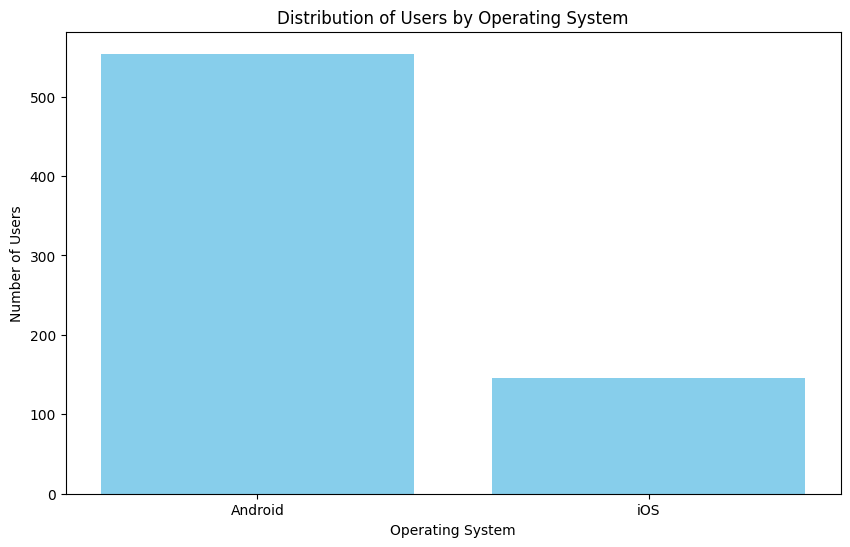

In [11]:
# Get operating system
os_distribution = df['Operating System'].value_counts().to_dict()

# Extract operating systems and their respective counts
operating_systems = list(os_distribution.keys())
user_counts = list(os_distribution.values())

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(operating_systems, user_counts, color='skyblue')

# Add labels and title
plt.xlabel('Operating System')
plt.ylabel('Number of Users')
plt.title('Distribution of Users by Operating System')

# Display the chart
plt.show()


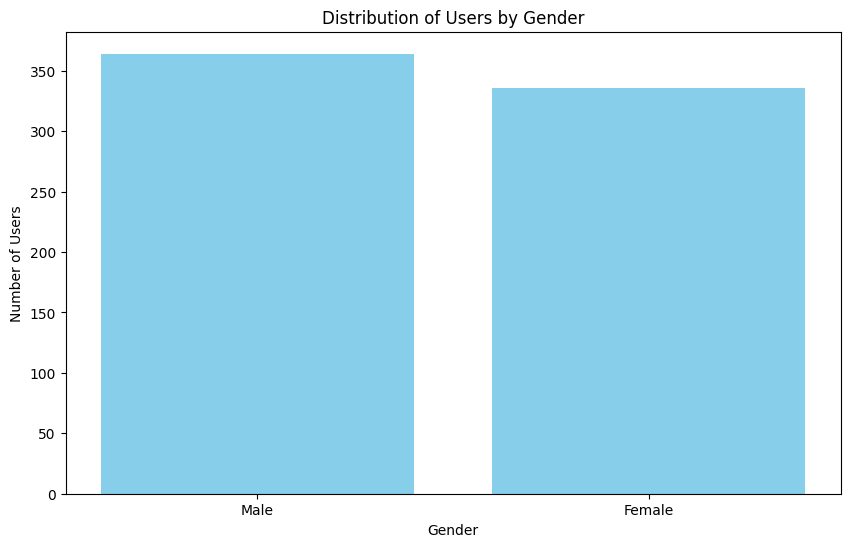

In [12]:
# Get gender data
gender_distribution = df['Gender'].value_counts().to_dict()

# Extract genders and their respective counts
gender_types = list(gender_distribution.keys())
user_counts = list(gender_distribution.values())

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(gender_types, user_counts, color='skyblue')

# Add labels and title
plt.xlabel('Gender')
plt.ylabel('Number of Users')
plt.title('Distribution of Users by Gender')

# Display the chart
plt.show()

In [18]:
# Distribution of 'Age'
age_distribution = df['Age'].value_counts().to_dict()

# Create list of ages based on the distribution
ages = []
for age, count in age_distribution.items():
    ages.extend([age] * count)

# Convert the list of ages to a pandas DataFrame for Plotly
ages_df = pd.DataFrame(ages, columns=['Age'])

# Create a histogram using Plotly
fig = px.histogram(ages_df, 
                   x='Age', 
                   nbins=10,  # Number of bins
                   title='Distribution of Ages',
                   labels={'Age': 'Age'},
                   opacity=0.7)

# Customize layout (optional)
fig.update_layout(
    xaxis_title='Age',
    yaxis_title='Frequency',
    bargap=0.1  # Adjust the gap between bars
)

# Show the interactive histogram
fig.show()

In [14]:
# Chart 4: Scatter plot - Relationship between 'App Usage Time (min/day)' and 'Battery Drain (mAh/day)'
scatter_data = df[['App Usage Time (min/day)', 'Battery Drain (mAh/day)']].to_dict('records')

# Convert the list of dictionaries into a format Plotly can use
df_scatter = pd.DataFrame(scatter_data)

# Create scatter plot using Plotly Express
fig = px.scatter(df_scatter, 
                 x='App Usage Time (min/day)', 
                 y='Battery Drain (mAh/day)', 
                 title='App Usage Time vs. Battery Drain',
                 labels={'App Usage Time (min/day)': 'App Usage Time (min/day)', 
                         'Battery Drain (mAh/day)': 'Battery Drain (mAh/day)'})

# Show the interactive plot
fig.show()

In [19]:
# Chart 5: Box Plot - Distribution of 'Screen On Time (hours/day)' for each 'User Behavior Class'
box_plot_data = df.groupby('User Behavior Class')['Screen On Time (hours/day)'].apply(list).to_dict()

# Convert the dictionary into a DataFrame for Plotly
df_boxplot = pd.DataFrame({
    'User Behavior Class': [key for key in box_plot_data for _ in box_plot_data[key]],
    'Screen On Time (hours/day)': [value for values in box_plot_data.values() for value in values]
})

# Create the box plot using Plotly Express
fig = px.box(df_boxplot, 
             x='User Behavior Class', 
             y='Screen On Time (hours/day)', 
             title='Distribution of Screen On Time by User Behavior Class',
             labels={'User Behavior Class': 'User Behavior Class',
                     'Screen On Time (hours/day)': 'Screen On Time (hours/day)'})

# Customize layout (optional)
fig.update_layout(
    xaxis_title='User Behavior Class',
    yaxis_title='Screen On Time (hours/day)',
    boxmode='group'  # Group the boxes for each category
)

# Show the interactive box plot
fig.show()

In [25]:
# Chart 6: Heatmap - Correlation between all the numerical variables in the dataset.
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
correlation_data = df[numeric_columns].corr()

color_scale = [
    [0, 'blue'],  # -1 -> blue
    [0.5, 'grey'],  # 0 -> grey
    [1, 'red']  # 1 -> red
]

# Create a heatmap using Plotly with the custom color scale
fig = px.imshow(correlation_data, 
                text_auto=True,  # Display correlation values on the heatmap
                aspect="auto",   # Automatically adjusts the aspect ratio
                title="Correlation Matrix Heatmap",
                color_continuous_scale=color_scale,
                zmin=-1,  # Set minimum value for color scale
                zmax=1)   # Set maximum value for color scale

# Customize layout
fig.update_layout(
    xaxis_title="Numeric Columns",
    yaxis_title="Numeric Columns"
)

# Show the interactive heatmap
fig.show()